Observationally, dense cores are often found in strands of high density gas with magnetic field through them. In the ``MHDSphere`` example, we try to model this by initializing a magnetic field in the z direction through our rotating, collapsing sphere.

![test](https://github.com/dorisjlee/remote/blob/master/astroSim-tutorial-img/hourglass.png?raw=True)

Hourglass-shaped magnetic field in dense core NGC 1333 IRAS 4A ([Girart et al., 2006](https://www.cfa.harvard.edu/sma/research/imageGallery/sciPages/JGirart/))

The strength of the magnetic field is often characterized by the variable $\beta$ (so-called `plasma beta'). Since we have already used $\beta$ for the rotation parameter, let's use $\alpha$ instead. 

The magnetic field exerts a pressure on the gas with magnitude (cgs)
$$ P_{B} = B^2/8\pi, $$
where $B$ is the magnitude of the magnetic field $B=|\vec{B}|$. The ratio of the thermal pressure to the magnetic pressure is the plasma `$\alpha$':
$$ \alpha = \frac{P_T}{P_B} = \frac{\rho c^2}{B^2/8\pi}\ .$$
where $P_T$ is the thermal pressure.
 So it is easily shown that the magnetic field is determined by the single parameter $\alpha$,
$$B=\sqrt{\frac{8\pi P_T}{\alpha}}$$
Small values of $\alpha$ imply strong magnetic fields. Observations of clouds typically reveal $\alpha$ values $\leq 1$, implying that the magnetic field can play a dynamic role in the star formation process. 

In setting up the initial magnetic field, you can use the equation above to solve for $B$ as a function of $\alpha$, $\rho$, and $c_s$. For simple initial conditions, try setting up a uniform magnetic field in the $z$-direction. In that case $B_z=B$. 

We perform the simulation without rotation ($\beta=0$) with a strong magnetic field ($\alpha \sim 0.1$) and no sink particles.



#### Adding alpha as a new parameter 

Inside Simulation_init(): 
~~~fortran
call RuntimeParameters_get('alpha',alpha) ! thermal-to-magnetic pressure ratio
~~~
Inside Simulation_data: 
~~~fortran
real, save :: sim_rhoLeft, sim_rhoRight, sim_pLeft, sim_pRight, fattening_factor,beta_param,alpha
~~~

Inside Config declare new variable: 
    
    PARAMETER alpha REAL 1.

# Initializing magnetic fields in Simulation_initBlock.F90

~~~fortran
use Simulation_data, ONLY: sim_smallX, sim_gamma, sim_smallP,fattening_factor,beta_param,alpha
~~~

In [10]:
8*pi

25.132741228718345

~~~fortran
   ! MHD
   Bz = sqrt(25.132*presZone/alpha)
   call Grid_putPointData(blockId, CENTER, MAGX_VAR, EXTERIOR, axis, 0.0)
   call Grid_putPointData(blockId, CENTER, MAGY_VAR, EXTERIOR, axis, 0.0)
   call Grid_putPointData(blockId, CENTER, MAGZ_VAR, EXTERIOR, axis, Bz)
~~~

# Setting up MHD in FLASH 

There are two types of MHD solvers in FLASH: the 8 wave solver and the unsplit staggered mesh solver. Our experience caused magnetic fields to become very small during the simulation and the 8 wave solver seems to resolve that issue. 

Inside Config load in the 8 wave solver:
~~~fortran
REQUESTS physics/Hydro/HydroMain/split/MHD_8Wave
~~~

To use these solvers include the flag +8wave in ./setup: 

    ./setup MHDRotatingSinkSphere -3d +8wave --maxblock=500 -auto ; cd object/;make -j8;
    
The code up to now is in ``examples/MHDSphere``.

# Analyzing MHD data with yt

In [1]:
%pylab inline 
from scripts.plotSim import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ~/proj/dlee/FLASH4.3/object/

/global/project/projectdirs/astro250/dlee/FLASH4.3/object


In [16]:
ds = yt.load("sphere_hdf5_chk_0000")
data = ds.all_data()

During MHD runs, FLASH stores 3 extra variable for $B_{x,y,z}$. We can look at the derived field to see some additional interesting fields: 

In [67]:
filter(lambda x: 'magnetic' in x[1] , ds.derived_field_list)

[('gas', 'magnetic_energy'),
 ('gas', 'magnetic_field_poloidal'),
 ('gas', 'magnetic_field_strength'),
 ('gas', 'magnetic_field_toroidal'),
 ('gas', 'magnetic_field_x'),
 ('gas', 'magnetic_field_y'),
 ('gas', 'magnetic_field_z'),
 ('gas', 'magnetic_pressure')]

We want to make sure that our magnetic fields are initialized correctly, one easy way to check this is to see whether the magnitude of the magnetic fields that we initialized corresponds to the beta that we set.

In [28]:
data["plasma_beta"]

YTArray([ 0.00795798,  0.00795798,  0.00795798, ...,  0.00795798,
        0.00795798,  0.00795798]) (dimensionless)

In [32]:
data["pressure"]/data["magnetic_pressure"]

YTArray([ 0.00795798,  0.00795798,  0.00795798, ...,  0.00795798,
        0.00795798,  0.00795798]) cm**2*g/(erg*s**2)

This is not exactly the $\beta=0.1$ that we set, the difference is too large to be accounted for a roundoff issue. Turns out that FLASH solves the MHD equations in non-dimensional scheme (see Eq 14.17-24 [here](http://flash.uchicago.edu/site/flashcode/user_support/flash4_ug_4p3/node21.html#SECTION06230000000000000000)), which means that $B_{\rm simulation} = \frac{B_{\rm actual}}{\sqrt{4\pi}}$. By default, yt assumes cgs and does not recognize this factor of $\sqrt{4\pi}$ when computing the magnetic pressure and strengths, so we need to include this factor. We can check that $\alpha$ correspond to our input parameter : 


In [71]:
B_actual = data["magnetic_field_strength"]/sqrt(4*pi)

Recall that magnetic pressure is defined as:  
$$P_B = \frac{B^2}{\sqrt{4\pi}}$$

In [72]:
B_pressure_actual = B_actual**2/(8*pi)

In [74]:
beta_actual = data["pressure"]/B_pressure_actual

In [75]:
beta_actual

YTArray([ 0.10000295,  0.10000295,  0.10000295, ...,  0.10000295,
        0.10000295,  0.10000295]) g/(cm*gauss**2*s**2)

This is pretty much $\beta$=0.1 :

In [87]:
np.unique(np.isclose(beta_actual,0.1,rtol=1e-4))[0]

True

# Visualizing MHD data with yt 

This is a slice plot through the x axes, the magnetic field streamline is plotted in orange.


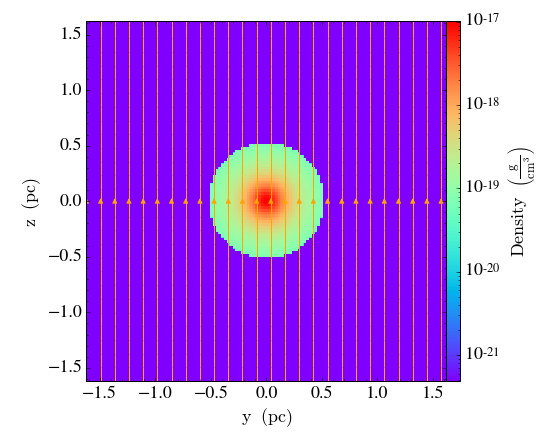

In [11]:
plot_var(0,cut="x",physical_quantity="density",magnetic=True,scale=False,velocity=True)

Timestep 198 is the last timestep, we could see that the magnetic field turns into an hourglass shape.


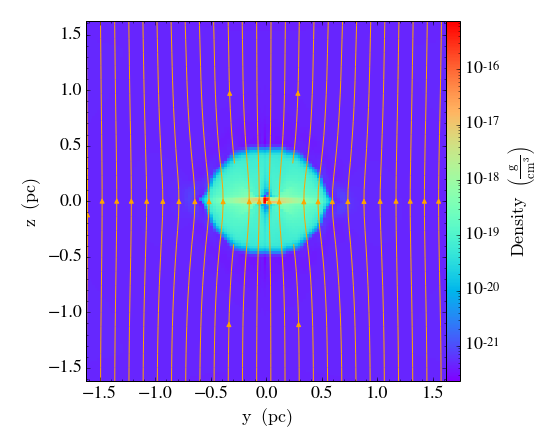


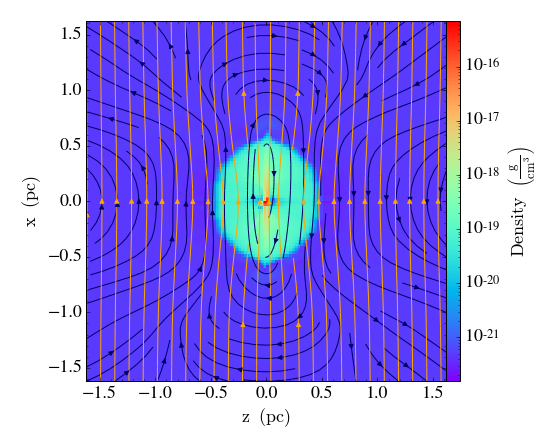

In [10]:
plot_var(198,cut="x",physical_quantity="density",magnetic=True)
plot_var(198,cut="y",physical_quantity="density",magnetic=True,velocity=True)

Because we don't have sink particles in this algorithm, the simulation terminated early. It is also interesting to look at a slice through the z direction. The velocity streamlines are plotted in dark blue, we could see that matter is flowing out along the magnetic field, causing it to become the elongated shape shown in the x or y slice.


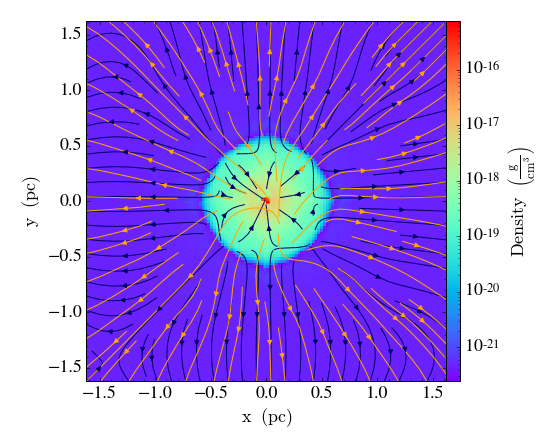

In [9]:
plot_var(198,cut="z",physical_quantity="density",velocity=True,magnetic=True)

We could also take a look at the magnetic field strength of the sphere: 


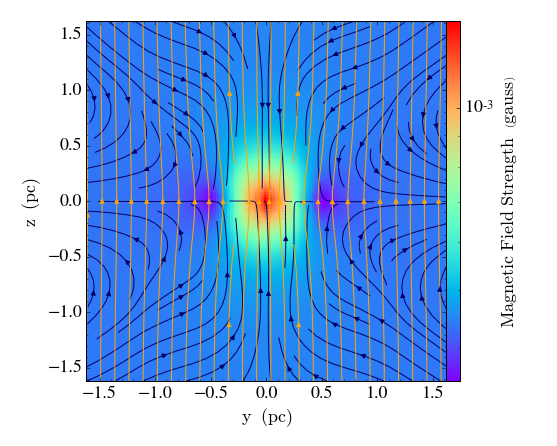

In [13]:
plot_var(198,cut="x",physical_quantity="magnetic_field_strength",velocity=True,magnetic=True)


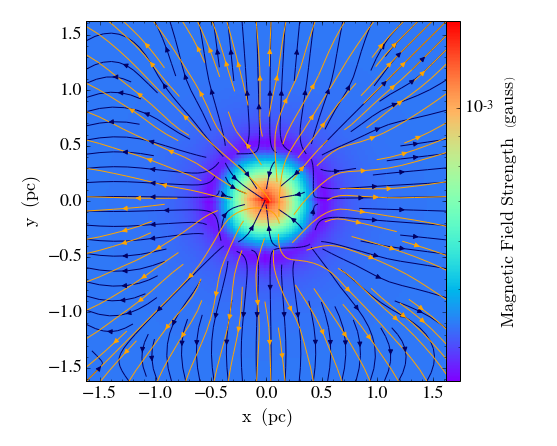

In [12]:
plot_var(198,cut="z",physical_quantity="magnetic_field_strength",velocity=True,magnetic=True)

This movie shows how to magnetic field and velocities evolves over time: 
